<h1>Data dimensionality and chance patterns that may return as significant</h1>

In this notebook we will explore the potential for patterns to arise by chance in data as we increase the number of features in a dataset. We create what is essentially a null model by randomly generating a dataset and performing some significance tests (a <i>t</i>-test in this case) on the features to assess what chance can achieve in terms of significant differences between randomly assigned classes.

We find that the proportion of significant features over many tests tends towards the alpha level of significance we are using; i.e., ~5% (1/20 or 0.05) of features will randomly contain a "signal" at the typical alpha level of significance ($p$ = 0.05), or, more elegantly, the proportion of significant features ($P$) will approximately equal the alpha level of significance ($\alpha$):

$$P \approx \alpha$$

The number of likely significant features ($F_{s}$) of the total number of features ($F$) is approximately:

$$F_{s} \approx F \cdot \alpha$$

If we have a dataset containing 20 features, 1 would be expected to test as significant by chance with an $\alpha$ of 0.05: 

$$F_{s} \approx F \cdot \alpha \approx 20 \cdot 0.05 \approx 1$$

However, spectral datasets typically contain hundreds or thousands of features. For instance, a typical fingerprint region of an FTIR dataset contains ~400 features. Using an alpha level of significance of approximately 0.05, we might expect that:

$$F_{s} \approx F \cdot \alpha \approx 400 \cdot 0.05 \approx 20$$

We would expect around 20 features to test as significant by chance in a dataset generated at random.

Obviously we are not dealing with random datasets and may not be using algorithms that use stistical tests, but given this potential, it is important to consider whether machine learning algorithms are finding genuine, useful patterns in our data. As we increase the dimensionality of our data (the number of features), we increase the potential for algorithms to find chance patterns. Ultimately we may be fooled into thinking that we have found genuine, predictable differences between our samples.

This is demostrated in the following code.

<h4>Loading libraries, assigning functions and setting plotting options</h4>
call.do() is simply a switch of arguments from do.call() that allows it to be used easily in piped code

In [1]:
library(parallel)
library(dplyr)
library(ggplot2)
library(tidyr)
call.do <- function(args, what){do.call(what, args)}
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"

<h4>Creating a set of data randomly drawn from a uniform distribution. It has 8192 observations and 1024 features. (Many features are typical of spectra.)</h4>

In [2]:
nObservation <- 2^13
nFeature <- 2^10
set.seed(1138)
randomData <- lapply(1:nObservation, function(i){runif(nFeature)}) %>% call.do(rbind)
dim(randomData)

[1] 8192 1024

<h4>Randomly assigning observations to one of two groups, a and b, and adding that to the randomly generated data</h4>

In [3]:
nGroup <- 2 # this script will only run with two groups as we as using a t-test as a test of significance
classSize <- nObservation / nGroup
randomGroup <- rep(letters[1:nGroup], each = classSize)
randomData <- data.frame(randomData) %>% cbind(data.frame(group = randomGroup))

<h4>Establishing a sequence of numbers to iterate. It is base 2 where each number is double the previous one in the sequence, so in a small sequence we can explore quite different sizes of datasets. We will use it to iterate over various numbers of randomly selected observations and features</h4>

[1]    4    8   16   32   64  128  256  512 1024

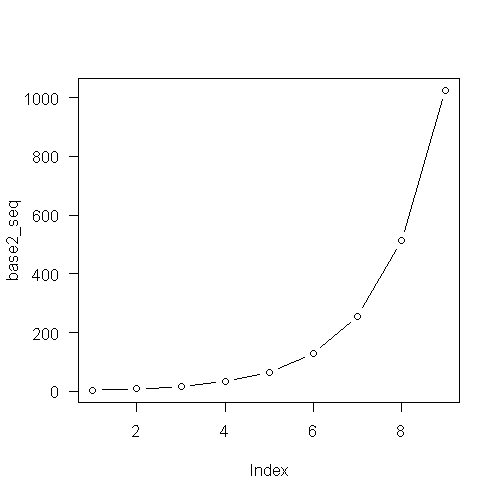

In [4]:
(base2_seq <- 2^c(2:10))
plot(base2_seq, type = "b", las = 1)

<h4>Defining a couple of functions to randomly subset data in terms of observations and features. This will happen many times to demonstrate that the tendency of a significant result is a function of the alpha level of significance of the statistical test.</h4>

In [5]:
subsampleObs <- function(n){
    randomData %>% 
    split(randomData$group) %>% 
    lapply(function(x){x[sample(nrow(x), n), ]})
}

subsampleData <- function(nObs, nFeatures){
    subSample <- subsampleObs(nObs) %>% call.do(rbind)
    groups <- subSample$group
    subSample <- subSample %>% 
    group_by(group) %>% 
    sample(nFeatures) %>% 
    ungroup()
    subSample$group <- groups
    return(subSample)
}

X724,X964,X680,X672,group
0.91325417,0.91356999,0.24879003,0.7744510,a
0.31943702,0.80814421,0.87576071,0.0266545,a
0.83799467,0.11916436,0.92487120,0.8930405,a
0.50749201,0.30984967,0.80390678,0.9311738,a
0.83215577,0.05320815,0.26137463,0.3662314,a
0.04496013,0.62565044,0.59033348,0.5541183,a
0.78673155,0.69675860,0.04321533,0.2788866,a
0.33946182,0.48922367,0.22549794,0.2260483,a
0.70547272,0.02456188,0.10982789,0.5146272,b
0.47156608,0.56404949,0.89785499,0.9215434,b


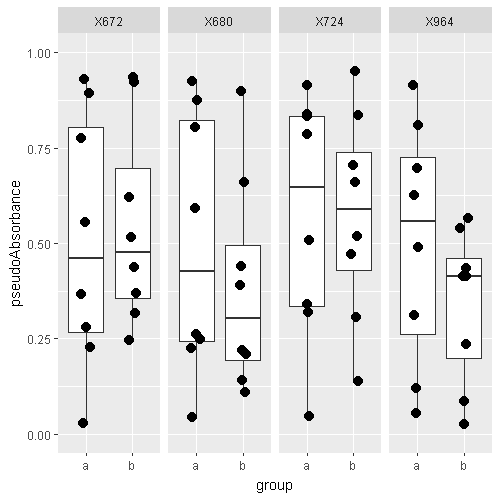

In [6]:
# This is an example of the output it produces given its input parameters: 
# 8 randomly selected observations of each class and 4 randomly selected features
# For each iteration, this subsampling will be performed 100 times and a t-test applied
(exampleData <- subsampleData(nObs = 8, nFeatures = 4))
exampleData %>% 
    gather("pseudoWavenumber", "pseudoAbsorbance", -group) %>%
    ggplot(aes(group, pseudoAbsorbance)) +
    scale_y_continuous(limits = c(0, 1)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(size = 3, width = 0.1) +
    facet_wrap(~pseudoWavenumber, nrow = 1)

<h4>Generating a table of values to iterate over (# of observations, # of features and p-value we are taking as significant and we will store the percentage of significantly different features in the column</h4>

In [7]:
print("thisManyObservations")
(thisManyObservations <- base2_seq[c(2, 5)])
print("thisManyFeatures")
(thisManyFeatures <- base2_seq[seq(1, 9, 2)])
print("thesePValues")
(thesePValues <- c(0.05, 0.01))

iterationTable <- expand.grid(nFeatures = thisManyFeatures, 
                              nObs = thisManyObservations, 
                              nTimes = 100, 
                              pValue = thesePValues, 
                              percSignificant = NA)
iterationTable
nrow(iterationTable)

[1] "thisManyObservations"


[1]  8 64

[1] "thisManyFeatures"


[1]    4   16   64  256 1024

[1] "thesePValues"


[1] 0.05 0.01

nFeatures,nObs,nTimes,pValue,percSignificant
4,8,100,0.05,NA
16,8,100,0.05,NA
64,8,100,0.05,NA
256,8,100,0.05,NA
1024,8,100,0.05,NA
4,64,100,0.05,NA
16,64,100,0.05,NA
64,64,100,0.05,NA
256,64,100,0.05,NA
1024,64,100,0.05,NA


[1] 20

<h4>If you already have the iterationTable file, you can load it here instead of running the loop below and save time</h4>

In [52]:
iterationTable <- readRDS("DD&CP iterationTable.RDS")

<h4>This next loop iterates over the above table and get our results. This may take a few minutes.</h4>

In [8]:
for(i in 1:nrow(iterationTable)){
  sigProps <- mclapply(1:iterationTable$nTimes[i], function(x){
    testData <- subsampleData(iterationTable$nObs[i], iterationTable$nFeatures[i])
    pSig <- sapply(1:(ncol(testData) - 1), function(x){
      groups <- testData$group
      testData$group <- NULL
      groups -> testData$group
      dat <- testData[c(x, ncol(testData))]        
      names(dat) <- c("var", "group")
      t.test(var ~ as.factor(group), dat)$p.value})
    return(sum(pSig <= iterationTable$pValue[i]))
  }) %>% unlist()
  iterationTable$nSignificant[i] <- sum(sigProps)
}

<h4>Adding some columns for average percentage of significant features (percSignificant), the proportion of significant features (pSignificant) and the number of significant features (nSigFeatures)</h4>

In [9]:
iterationTable <- iterationTable %>% mutate(percSignificant = nSignificant / nTimes,
                                            pSignificant = percSignificant / nFeatures,
                                            nSigFeatures = pSignificant * nFeatures)
iterationTable

nFeatures,nObs,nTimes,pValue,percSignificant,nSignificant,pSignificant,nSigFeatures
4,8,100,0.05,0.15,15,0.03750000,0.15
16,8,100,0.05,0.82,82,0.05125000,0.82
64,8,100,0.05,2.96,296,0.04625000,2.96
256,8,100,0.05,12.40,1240,0.04843750,12.40
1024,8,100,0.05,51.67,5167,0.05045898,51.67
4,64,100,0.05,0.19,19,0.04750000,0.19
16,64,100,0.05,0.81,81,0.05062500,0.81
64,64,100,0.05,2.96,296,0.04625000,2.96
256,64,100,0.05,12.90,1290,0.05039063,12.90
1024,64,100,0.05,51.57,5157,0.05036133,51.57


<h4>You can save the data by uncommenting the below line of code</h4>

In [23]:
# saveRDS(iterationTable, "DD&CP iterationTable.RDS")

<h4>We can see from these many iterations that randomly generated data can yield a number of significantly different features that is directly proportional to the level of significance we measure at.</h4>

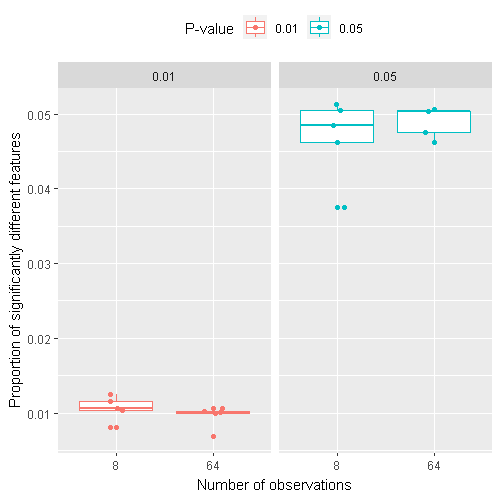

In [10]:
iterationTable %>% 
    ggplot(aes(as.factor(nObs), pSignificant, col = as.factor(pValue))) + 
    geom_boxplot() + 
    geom_jitter(width = 0.1) +
    labs(x = "Number of observations", y = "Proportion of significantly different features") +
    scale_colour_discrete(name = "P-value") +
    theme(legend.position = "top") +
    facet_wrap(~pValue)

<h4>What is most concerning about patterns (significant features) in noise, from a machine learning perspective, is that as the number of features increases, the number of significant features can increase proportionally with the alpha level of significance of our significance test. The number of observations in this example does not impact the result.</h4>

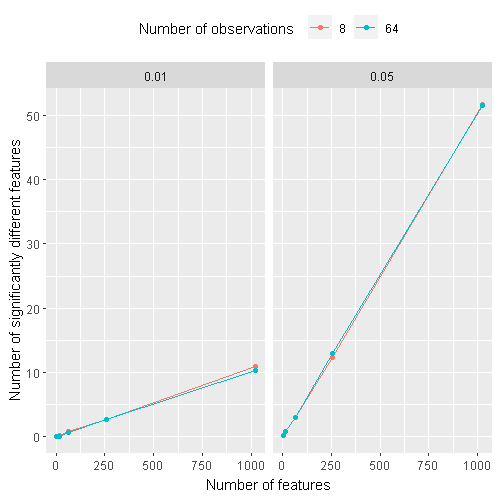

In [11]:
iterationTable %>% 
    ggplot(aes(nFeatures, nSigFeatures, col = as.factor(nObs))) + 
    geom_line() + 
    geom_point() +
    labs(x = "Number of features", y = "Number of significantly different features") +
    scale_colour_discrete(name = "Number of observations") +
    theme(legend.position = "top") +
    facet_wrap(~pValue)

<h2>In other words, <u>as the number of features increase</u>, machine learning algorithms are given <u>more opportunity to learn patterns that arise from chance/noise</u>.</h2>

<h4>Because of this statistical likelihood we can be fooled into thinking that we can distinguish between different classes. The fact that we are being fooled will not necessarily be evident from accuracy scores or other metrics such as Cohen's Kappa. This is where, wherever possible, we must use our specialist knowledge to scrutinise the decision-making behaviour of the algorithm.</h4> 

<h4>In some instances it may not be able to peer into the black box of the algorithm, so it is doubly important that caution must be used when interpreting model results where large numbers of features are present in the data.</h4>

<ul>
    <li>We should assume that some features will return as significant <b>by chance</b></li>
    <li>Some algorithms use significance tests or make decisions similarly, therefore:
        <ul>
        <li>It is likely that the proportion of potential chance significant features approximately equals the alpha level of significance</li>
        <li>It is likely prudent to check that there are many (a threshold) more significant features than the alpha level of significance</li>
        </ul>
    <li>We should be mindful when using feature selection algorithms</li>
    <li>We should use subject-specific knowedge where possible</li>
</ul>

Notes to self:
Should we use something like the Bonferroni correction and set alpha = 1/n (n = # of wavenumbers)